In [257]:
from scipy.ndimage import binary_dilation, binary_erosion, zoom
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import random
import os

In [258]:
class PictureDamager:
    def __init__(self, masks: np.array, stain_percentage: float):
        self.stain_percentage = stain_percentage
        self.masks = masks

    def expected_num_of_stains(self, mask_size):
        return mask_size[0] * mask_size[1] * self.stain_percentage

    def mask_randomizer(self, mask, resize_prob, morph_transform_prob):
        if random.random() < resize_prob:
            enlarge = random.random() < 0.5
            if enlarge:
                if random.random() < 0.5:
                    mask = zoom(mask, (2, 2), order=0)
                else:
                    mask = zoom(mask, (3, 3), order=0)
            else:
                mask = zoom(mask, (0.5, 0.5), order=0)

        if random.random() < morph_transform_prob:
            dilate = random.random() < 0.5
            if dilate:
                mask = binary_dilation(mask).astype(np.uint8)
            else:
                mask = binary_erosion(mask).astype(np.uint8)

        if random.random() < 0.5:
            mask = mask.T

        if random.random() < 0.5:
            mask = np.flipud(mask)

        if random.random() < 0.5:
            mask = np.fliplr(mask)

        return np.array(mask)

    def generate_random_mask(self, mask_size):
        damaged_mask = np.zeros(mask_size, dtype=np.uint8)
        stains_counter = 0

        while stains_counter < self.expected_num_of_stains(mask_size):
            mask = random.choice(self.masks)
            mask = self.mask_randomizer(mask, 0.5, 0.5)

            mask_height, mask_width = mask.shape
            if mask_height > mask_size[0] or mask_width > mask_size[1]:
                continue

            x = random.randint(0, mask_size[0] - mask_height)
            y = random.randint(0, mask_size[1] - mask_width)

            damaged_mask[x:x+mask_height, y:y+mask_width] = np.where(
                mask == 1, 1, damaged_mask[x:x+mask_height, y:y+mask_width])

            stains_counter += np.sum(mask)

        return damaged_mask

    def add_masks_to_images(self, image_folder, output_folder, target_size=(256, 256)):
        os.makedirs(output_folder, exist_ok=True)

        for image_file in os.listdir(image_folder):
            if image_file.endswith('.png') or image_file.endswith('.jpg'):
                image = np.array(Image.open(os.path.join(image_folder, image_file)))

                if image.shape[-1] != 3:
                    print(f"Skipping {image_file} (not a 3-channel image)")
                    continue

                if image.shape[:2] != target_size:
                    print(f"Resizing image {image_file} from {image.shape[:2]} to {target_size}")
                    image = np.array(Image.fromarray(image).resize(target_size, Image.ANTIALIAS))

                mask = self.generate_random_mask(target_size)

                image_with_mask = np.dstack((image, mask))

                output_file = os.path.splitext(image_file)[0] + ".npy"
                np.save(os.path.join(output_folder, output_file), image_with_mask)

        print(f"Processed images saved to {output_folder}")

    def generate_damaged_images(self, image_folder_with_masks, output_folder):
        os.makedirs(output_folder, exist_ok=True)

        for file in os.listdir(image_folder_with_masks):
            if file.endswith('.npy'):
                image_with_mask = np.load(os.path.join(image_folder_with_masks, file))
                image, mask = image_with_mask[:, :, :3], image_with_mask[:, :, 3]

                damaged_image = np.where(mask[..., None] == 1, 255, image)

                output_file = os.path.splitext(file)[0] + "_damaged.png"
                Image.fromarray(damaged_image.astype(np.uint8)).save(os.path.join(output_folder, output_file))

        print(f"Damaged images saved to {output_folder}")

In [259]:
masks_path = "masksnpy"
MASKS = [np.load(os.path.join(masks_path, f)) for f in os.listdir(masks_path) if f.endswith(".npy")]  

In [260]:
damager = PictureDamager(MASKS, 1/16)

In [262]:
damager.add_masks_to_images(image_folder="pictures", output_folder="images_with_masks")

Resizing image my_photo.jpg from (2048, 2048) to (256, 256)
Processed images saved to images_with_masks


C:\Users\peter\AppData\Local\Temp\ipykernel_28192\681784900.py:73: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  image = np.array(Image.fromarray(image).resize(target_size, Image.ANTIALIAS))


In [263]:
damager.generate_damaged_images(image_folder_with_masks="images_with_masks", output_folder="damaged_images")

Damaged images saved to damaged_images


In [264]:
def compare_damaged_with_original(image_with_mask_path):
    image_with_mask = np.load(image_with_mask_path)

    original_image = image_with_mask[:, :, :3]  # rgb
    mask = image_with_mask[:, :, 3]            # Kanał 4 

    damaged_image = np.where(mask[..., None] == 1, 255, original_image)

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(original_image.astype(np.uint8))
    plt.title("Oryginalny obraz")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(damaged_image.astype(np.uint8))
    plt.title("Uszkodzony obraz")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

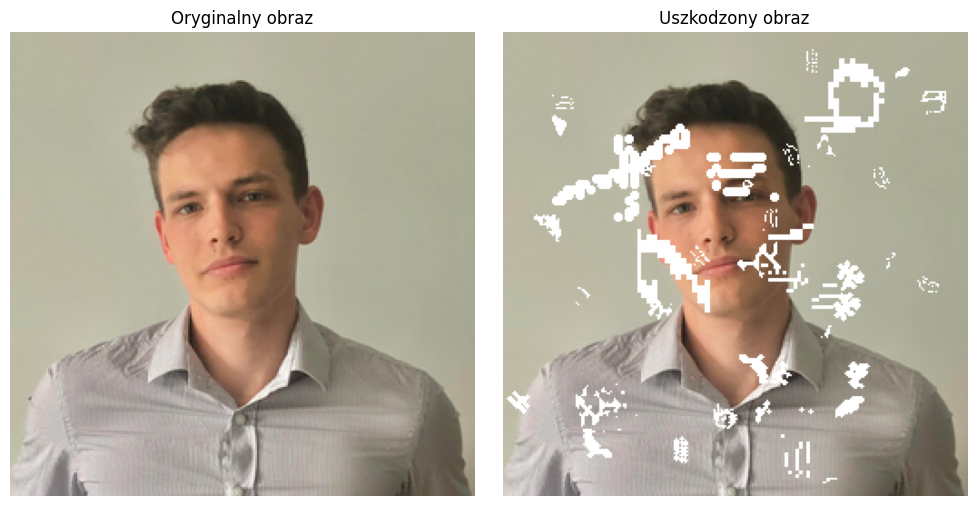

In [265]:
compare_damaged_with_original("images_with_masks/my_photo.npy")